In [ ]:
!pip install ipython-autotime
!pip install tensorflow==2.1.0
!pip install nltk
!pip install shap
!pip install wordcloud

In [ ]:
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

import shap
from wordcloud import WordCloud

%load_ext autotime

tf.random.set_seed(1)
print(tf.__version__)
plt.style.use('ggplot')

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',filename=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    
def plot_roc_curve(ground_truth, predictions, filename=None):
    fpr, tpr, thr = roc_curve(y_true=ground_truth, y_score=predictions, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(15,10))
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
         label='Chance', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    #return fpr, tpr, thr

def cross_validation_plot_roc_curve(ground_truth, predictions, filename=None):
    plt.figure(figsize=(15,10))
    i = 0
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for g, p in zip(ground_truth, predictions):
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_true = g, y_score = p, drop_intermediate=False)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    #return mean_fpr, mean_tpr
   

time: 123 ms


In [6]:
notes_filename = 'MIMICIII_sapsii_dataset_medical-notes.pickle'
notes = pd.read_pickle(notes_filename);
notes.sort_values(by=['subject_id', 'icu_time_hr'], ascending=[True, True], inplace=True)
print(notes['subject_id'].nunique())
notes.head(10)

21054


,subject_id,hadm_id,icustay_id,mort_icu,los,row_id,iserror,category,description,text,icu_time_hr
0,3,145834,211552,0,6.0646,768818,None,Radiology,CHEST (PORTABLE AP),[**2101-10-20**] 10:23 PM\n CHEST (PORTABLE AP...,3.0
1,3,145834,211552,0,6.0646,768829,None,Radiology,CHEST (PORTABLE AP),[**2101-10-21**] 1:00 AM\n CHEST (PORTABLE AP)...,6.0
2,3,145834,211552,0,6.0646,768834,None,Radiology,CHEST (PORTABLE AP),[**2101-10-21**] 6:10 AM\n CHEST (PORTABLE AP)...,11.0
3,3,145834,211552,0,6.0646,1260684,None,Nursing/other,Report,Micu Progress Nursing Note:\n\nPatient arrived...,12.0
4,3,145834,211552,0,6.0646,1260685,None,Nursing/other,Report,MICU NSG PROG NOTE: days\nRemains stable on hi...,19.0
5,3,145834,211552,0,6.0646,768885,None,Radiology,CHEST (PORTABLE AP),[**2101-10-21**] 4:43 PM\n CHEST (PORTABLE AP)...,22.0
6,6,107064,228232,0,3.6729,1260707,None,Nursing/other,Report,2230-0700\n\nRecieved pt from PACU following L...,7.0
7,6,107064,228232,0,3.6729,870938,None,Radiology,R RENAL TRANSPLANT U.S. RIGHT,[**2175-5-31**] 11:03 AM\n RENAL TRANSPLANT U....,14.0
8,6,107064,228232,0,3.6729,1260708,None,Nursing/other,Report,Nursing Note: see careview for complete detai...,20.0
9,9,150750,220597,1,5.3231,1260714,None,Nursing/other,Report,Respiratory Care:\n Pt. intubated in EW fo...,3.0


time: 445 ms


Nursing/other      42814
Radiology          39922
Nursing            21943
Physician          15253
Respiratory         3099
General             1082
Nutrition            759
Social Work          222
Rehab Services       174
Case Management       75
Consult               27
Pharmacy               5
Name: category, dtype: int64


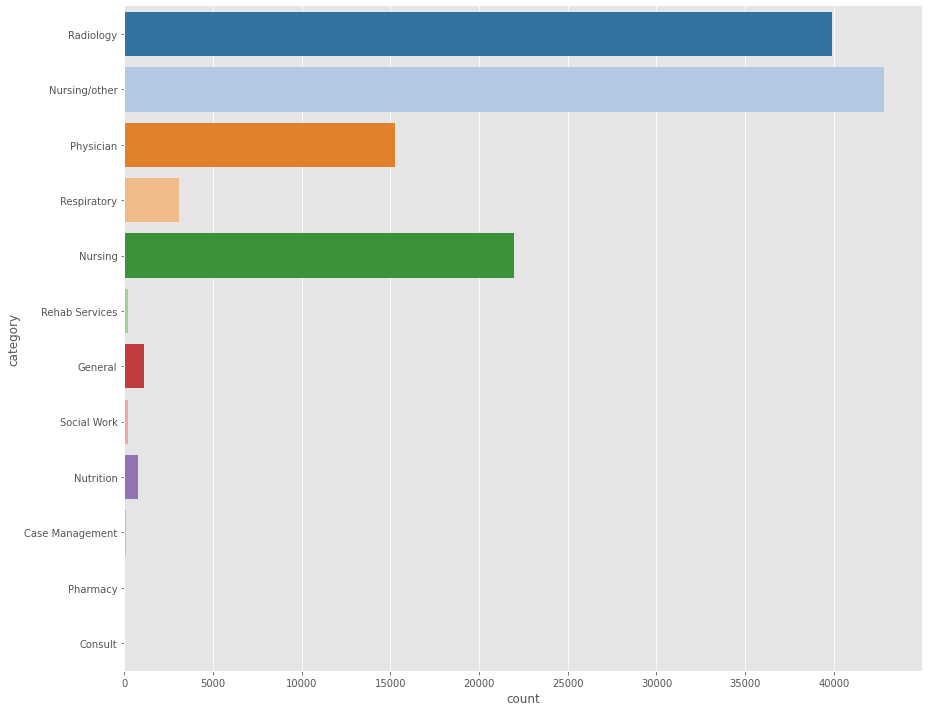

time: 4.99 s


In [7]:
sns.catplot(y='category', kind='count', palette="tab20", data=notes, height=10, aspect=1.3)
plt.tight_layout()
plt.savefig('note_distribution.png', dpi=500)
print(notes['category'].value_counts())

In [8]:
filtered_notes = notes[notes.category.isin(['Nursing/other', 'Radiology', 'Nursing', 'Physician'])]#.sample(frac=.10, random_state=42)
filtered_notes['category'].value_counts()

Nursing/other    42814
Radiology        39922
Nursing          21943
Physician        15253
Name: category, dtype: int64

time: 37.8 ms


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
f = lambda x: ' '.join([item for item in x.split() if item not in stops])
filtered_notes['text'] = filtered_notes['text'].apply(f)

In [10]:
mortality = filtered_notes[['subject_id','mort_icu']].drop_duplicates(subset=['subject_id'])[['mort_icu']].values

time: 14.9 ms


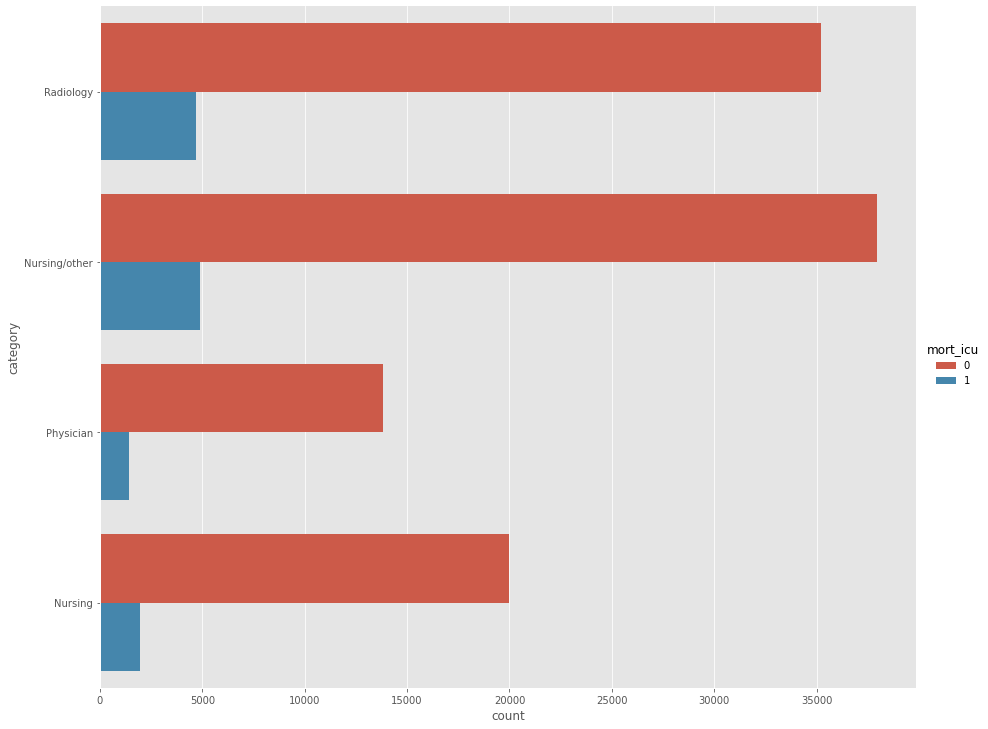

time: 5.27 s


In [11]:
g = sns.catplot(y='category', hue='mort_icu', kind='count', data=filtered_notes, height=10, aspect=1.3)
#g.text('Radiology','0', 100, color='black', ha="center")
plt.savefig('note_mortality.png', dpi=500)

In [12]:
pivoted_notes = filtered_notes.pivot_table(index=['subject_id', 'icu_time_hr'], columns='category', values='text', aggfunc=lambda t : '\n'.join(t))
pivoted_notes.loc[pivoted_notes['Nursing/other'] == '','Nursing/other'] = pivoted_notes[pivoted_notes['Nursing/other'] == '']['Nursing']
pivoted_notes.fillna('', inplace=True)

time: 1.15 s


In [13]:
print(len(pivoted_notes))
pivoted_notes.head(20)

83987


category               Nursing  ...                                          Radiology
subject_id icu_time_hr          ...                                                   
3          3.0                  ...  [**2101-10-20**] 10:23 PM CHEST (PORTABLE AP) ...
           6.0                  ...  [**2101-10-21**] 1:00 AM CHEST (PORTABLE AP) C...
           11.0                 ...  [**2101-10-21**] 6:10 AM CHEST (PORTABLE AP) C...
           12.0                 ...                                                   
           19.0                 ...                                                   
           22.0                 ...  [**2101-10-21**] 4:43 PM CHEST (PORTABLE AP) C...
6          7.0                  ...                                                   
           14.0                 ...  [**2175-5-31**] 11:03 AM RENAL TRANSPLANT U.S....
           20.0                 ...                                                   
9          3.0                  ...                                                   
           5.0                  ...                                                   
           16.0                 ...                                                   
           22.0                 ...  [**2149-11-10**] 11:07 AM CT HEAD W/O CONTRAST...
12         4.0                  ...                                                   
           7.0                  ...                                                   
           15.0                 ...                                                   
13         11.0                 ...  [**2167-1-9**] 6:11 AM CHEST (PORTABLE AP) Cli...
           16.0                 ...                                                   
           22.0                 ...  [**2167-1-9**] 4:51 PM CHEST (PORTABLE AP) IN ...
           24.0                 ...                                                   

[20 rows x 4 columns]

time: 27.6 ms


In [ ]:
print(pivoted_notes.loc[3].iloc[0]['Radiology'])

In [15]:
pivoted_notes_v2 = filtered_notes.pivot_table(index='subject_id', columns='category', values='text', aggfunc=lambda t : '\n'.join(t))
pivoted_notes_v2.loc[pivoted_notes_v2['Nursing/other'].isnull(),'Nursing/other'] = pivoted_notes_v2[pivoted_notes_v2['Nursing/other'].isnull()]['Nursing']
#pivoted_notes_v2.fillna('', inplace=True)
pivoted_notes_v2.dropna(axis=0, subset=['Nursing/other'], inplace=True)
print(len(pivoted_notes_v2))
pivoted_notes_v2.head(20)

16920


category,Nursing,Nursing/other,Physician,Radiology
subject_id,,,,
3,NaN,Micu Progress Nursing Note: Patient arrived un...,NaN,[**2101-10-20**] 10:23 PM CHEST (PORTABLE AP) ...
6,NaN,2230-0700 Recieved pt PACU following LR kidney...,NaN,[**2175-5-31**] 11:03 AM RENAL TRANSPLANT U.S....
9,NaN,Respiratory Care: Pt. intubated EW airway prot...,NaN,[**2149-11-10**] 11:07 AM CT HEAD W/O CONTRAST...
12,NaN,Respiratory Care: Patient admitted OR intubate...,NaN,NaN
13,NaN,CCU ADMISSION NPN 1900-0700: LEFT MAIN HPI: IN...,NaN,[**2167-1-9**] 6:11 AM CHEST (PORTABLE AP) Cli...
17,NaN,OP DAY MINIMALLY INVASIVE PFO REPAIR NSR. NO E...,NaN,NaN
21,NaN,"ADMISSION NOTE 87 YR OLD MAN WITH H/O CAD, CVA...",NaN,[**2134-9-12**] 10:48 AM CHEST (PORTABLE AP) C...
25,NaN,NURSING PROGRESS NOTE 58 Y/O MALE ADMITTED FRO...,NaN,NaN
26,NaN,"Nsg Progress Note Pt 72 yo man known CAD, S/P ...",NaN,NaN


time: 668 ms


In [ ]:
print(pivoted_notes_v2.loc[3]['Nursing/other'])

In [17]:
mortality = filtered_notes[['subject_id','mort_icu']].drop_duplicates(subset=['subject_id'])
mortality = mortality[mortality.subject_id.isin(pivoted_notes_v2.index.values)][['mort_icu']].values
mortality.shape

(16920, 1)

time: 14.4 ms


In [18]:
vocab_size = 100000
note_category = 'Nursing/other'
vocab = np.unique(np.concatenate(pivoted_notes_v2[[note_category]].values))
print(vocab.shape)
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(vocab)
notes_sequences = tokenizer.texts_to_sequences(pivoted_notes_v2[note_category].values)


(16920,)
time: 11.7 s


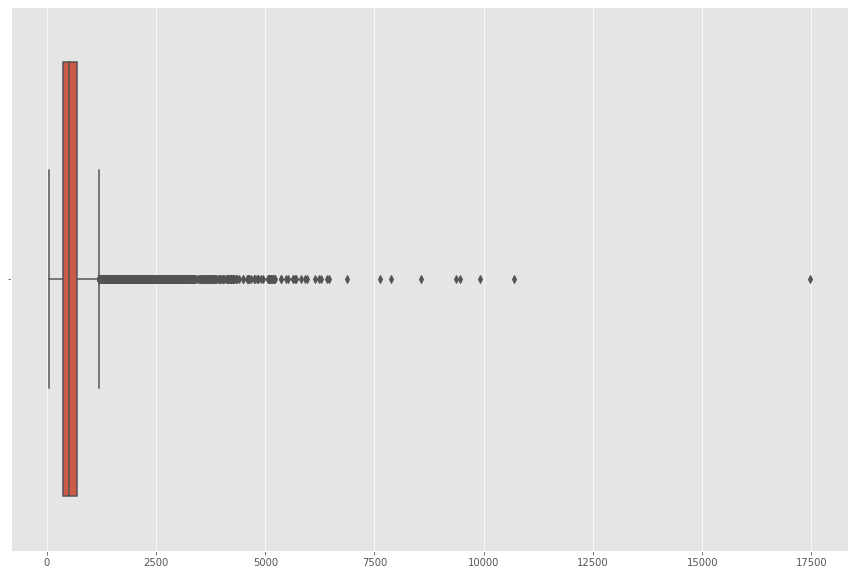

time: 5.34 s


In [19]:
plt.figure(figsize=(15,10))
sns.boxplot([len(x) for x in notes_sequences])
plt.savefig('note-length-box-plot.png', dpi=500)

In [20]:
sequence_max_length = 500
padded_notes_sequences = pad_sequences(notes_sequences, sequence_max_length, truncating='pre')
print(f'Total words: {len(tokenizer.word_index) + 1}')

Total words: 83756
time: 647 ms


In [21]:
embedding_dimension = 10

def create_model(output_bias=None):

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  notes_shape = (sequence_max_length, )
  notes_input = tf.keras.layers.Input(shape=notes_shape, name='notes')
  dense_vectors = tf.keras.layers.Embedding(input_dim=vocab_size + 1, 
                                            output_dim=embedding_dimension, 
                                            input_length=sequence_max_length)(notes_input)

  notes_embeddings = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,
                                                                        dropout=0.5,
                                                                        return_sequences=True),
                                                    name='bidirectional_lstm')(dense_vectors)
  notes_embeddings = tf.keras.layers.LSTM(100, dropout=0.5, name='lstm')(notes_embeddings)

  notes_embeddings = tf.keras.layers.Dropout(0.5, name = 'dropout')(notes_embeddings)
  fc1 = tf.keras.layers.Dense(50, 
                              activation='relu', 
                              kernel_initializer='he_normal',
                              name='fc1')(notes_embeddings)

  mortality = tf.keras.layers.Dense(1, 
                                    activation='sigmoid',
                                    kernel_initializer='he_normal',
                                    bias_initializer=output_bias,
                                    name='mortality')(fc1)

  return tf.keras.Model(inputs=notes_input, outputs=mortality)


def create_model_conv(output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  notes_shape = (sequence_max_length, )
  notes_input = tf.keras.layers.Input(shape=notes_shape, name='notes')

  dense_vectors = tf.keras.layers.Embedding(input_dim=vocab_size + 1, 
                                            output_dim=embedding_dimension, 
                                            input_length=sequence_max_length)(notes_input)
  
  dense_vectors = tf.keras.backend.expand_dims(dense_vectors, axis=3)

  notes_embeddings = tf.keras.layers.Conv2D(32, (5, embedding_dimension), activation='relu', padding='same')(dense_vectors)

  notes_embeddings = tf.keras.layers.MaxPool2D(pool_size = (1,3), padding = 'same')(notes_embeddings)

  notes_embeddings = tf.keras.layers.Flatten()(notes_embeddings)

  fc1 = tf.keras.layers.Dense(50, 
                              activation='relu', 
                              kernel_initializer='he_normal',
                              name='fc1')(notes_embeddings)

  mortality = tf.keras.layers.Dense(1, 
                                    activation='sigmoid',
                                    kernel_initializer='he_normal',
                                    bias_initializer=output_bias,
                                    name='mortality')(fc1)

  return tf.keras.Model(inputs=notes_input, outputs=mortality)

time: 33.2 ms


In [22]:
import re
import os
import shutil
def get_best_val_model(fold):
  filenames = [f for f in os.listdir(
          "./") if f.startswith(f"kfold{fold}_") and f.endswith(".h5")]

  metric_values_str = [re.findall('0.[0-9]+',f) for f in filenames]
  best_model_filename = filenames[np.argmax([get_F1(float(m[0]), float(m[1])) for m in metric_values_str])]
  print(best_model_filename)
  shutil.copy(best_model_filename, f'kfold{fold}_best_F1.h5')
  return tf.keras.models.load_model(best_model_filename)

def get_F1(precision, recall):
  try:
    return 2 * (precision * recall) / (precision + recall)
  except ZeroDivisionError:
    return 0

time: 10.1 ms


In [23]:
X = padded_notes_sequences
y = mortality

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_idx = list(cv.split(X=np.zeros(X.shape[0]), y=y))

time: 8.04 ms


In [24]:
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold


total = y.shape[0]
pos = y.sum()
neg = total - pos

num_epochs = 3
batch_size = 128
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

#history = model.fit(padded_notes_sequences, mortality, epochs=num_epochs, batch_size = batch_size, class_weight=class_weight)

predictions = []
predictions_training_set = []
ground_truth = []
ground_truth_training_set = []
fold_history = []


initial_bias = np.log([pos/neg])


i = 0
for train, validation in cv_idx:
    tf.keras.backend.clear_session()
    ground_truth_training_set.append(y[train])
    ground_truth.append(y[validation])
    print(f'Fold {i}. Positive examples in validation: {np.sum(y[validation])}...')
    model = create_model_conv(output_bias=initial_bias)
    #sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=True)
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    
    #checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=f'kfold{i}.h5', 
    #                                                   monitor='val_accuracy', save_best_only=True)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=f"kfold{i}_" + "precision_{val_precision:.5f}_recall_{val_recall:.5f}_loss_{val_loss:.5f}.h5",
                                            monitor='val_loss')
    fold_history.append(model.fit(x = X[train], y = y[train], 
                                  epochs = num_epochs, batch_size = batch_size, 
                                  class_weight=class_weight,
                                  callbacks=[checkpoint_cb],
                                  validation_data=(X[validation], 
                                                   y[validation])))
    
    
    model = get_best_val_model(i)
    predictions_training_set.append(model.predict(X[train]))
    predictions.append(model.predict(X[validation]))
    i += 1


Weight for class 0: 0.55
Weight for class 1: 5.12
Fold 0. Positive examples in validation: 330...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 13536 samples, validate on 3384 samples
Epoch 1/3
13536/13536 [==============================] - 9s 692us/sample - loss: 0.6553 - recall: 0.6213 - precision: 0.1504 - val_loss: 0.5954 - val_recall: 0.5242 - val_precision: 0.2712
Epoch 2/3
13536/13536 [==============================] - 2s 161us/sample - loss: 0.4872 - recall: 0.8178 - precision: 0.2705 - val_loss: 0.5386 - val_recall: 0.7394 - val_precision: 0.2387
Epoch 3/3
13536/13536 [==============================] - 2s 162us/sample - loss: 0.3245 - recall: 0.8957 - precision: 0.4263 - val_loss: 0.5845 - val_recall: 0.6515 - val_precision: 0.2587
kfold0_precision_0.25872_recall_0.65152_loss_0.58449.h5
Fold 1. Positive examples in validation: 330...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 13536 samples, validate on 3384 samples
Epoch 1/3
13536/13536 [==========

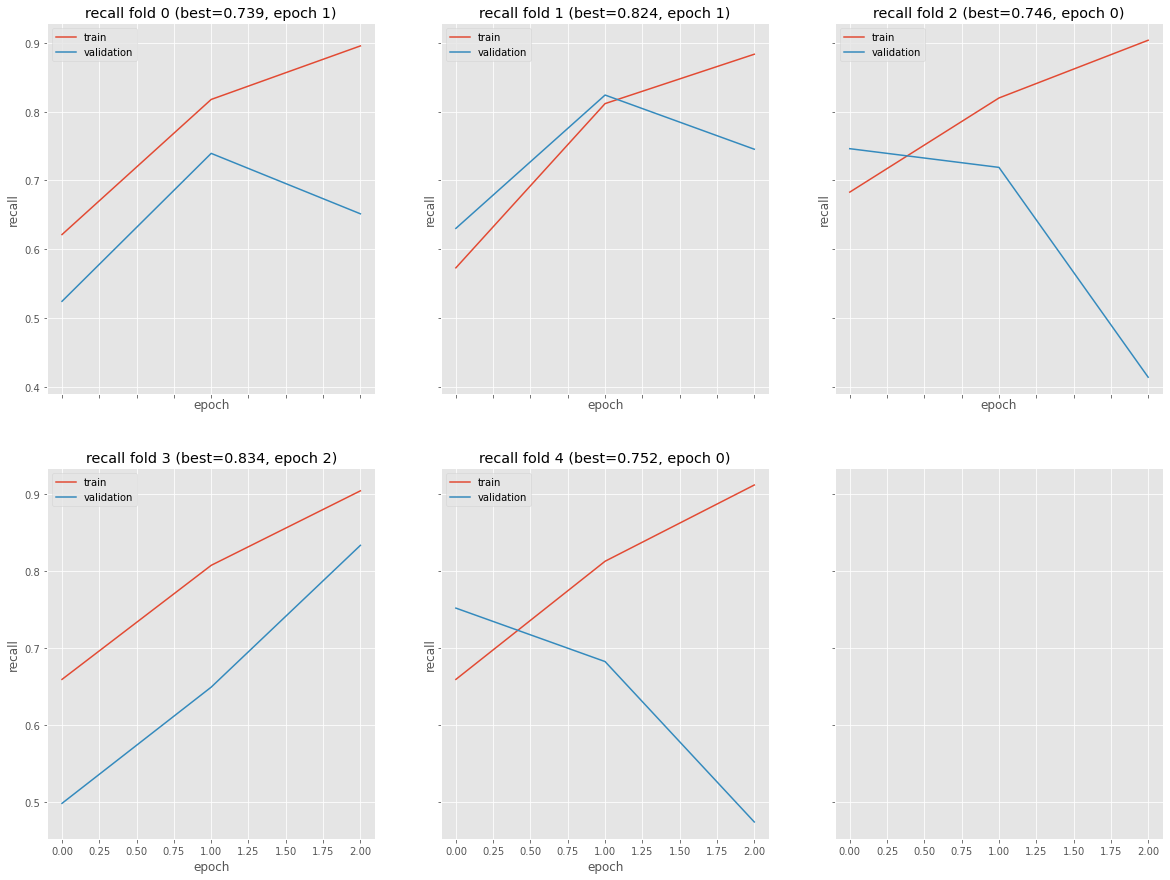

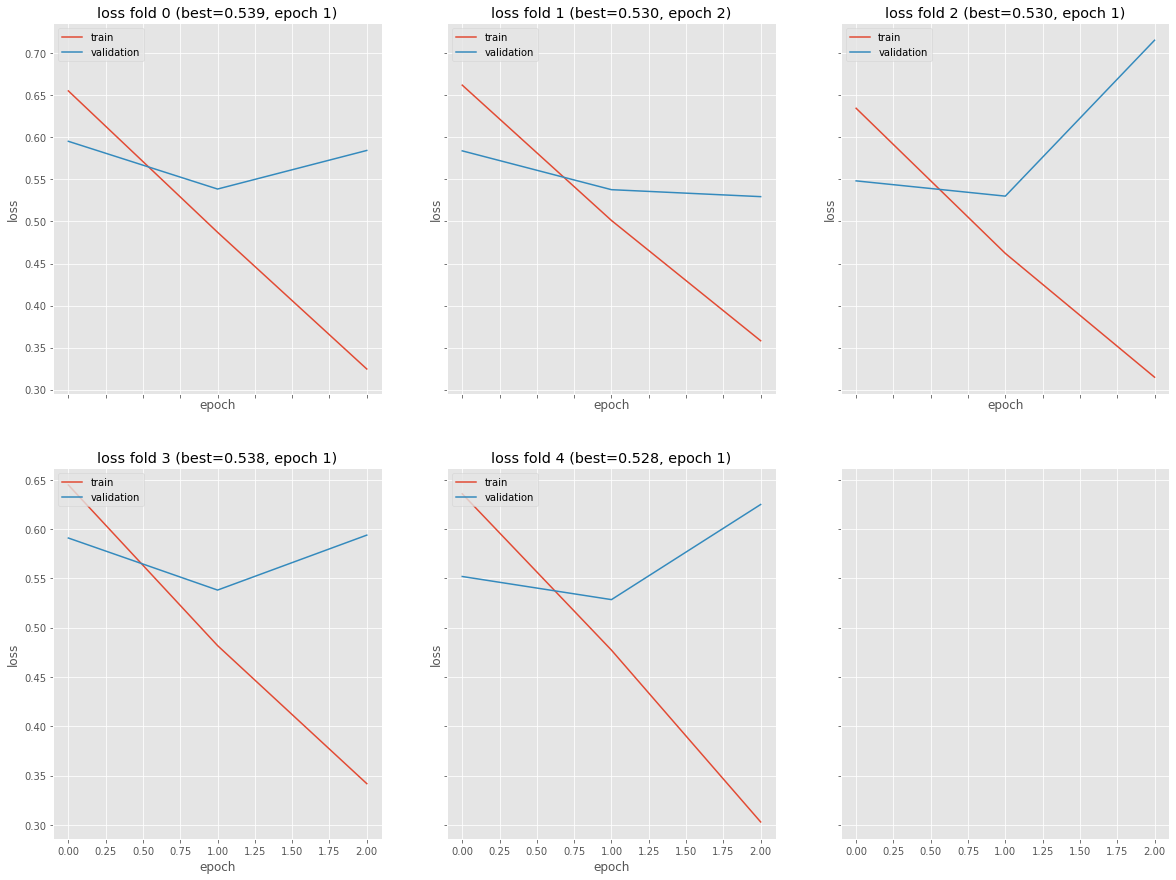

time: 24 s


In [25]:
def plot_history(metric='accuracy'):
  fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,15))
  for k, history in enumerate(fold_history):
      f = np.argmax
      if metric == 'loss':
        f = np.argmin
      j = f(history.history[f'val_{metric}'])
      
      ax[int(k // 3), k % 3].plot(history.history[metric])
      ax[int(k // 3), k % 3].plot(history.history[f'val_{metric}'])
      ax[int(k // 3), k % 3].set_title('{3} fold {0} (best={1:.3f}, epoch {2})'.format(k, history.history[f'val_{metric}'][j], j, metric))
      ax[int(k // 3), k % 3].set_ylabel(metric)
      ax[int(k // 3), k % 3].set_xlabel('epoch')
      ax[int(k // 3), k % 3].legend(['train', 'validation'], loc='upper left')
  plt.savefig(f'{metric}_history.png', dpi=500)
  plt.show()
  
plot_history('recall')
plot_history('loss')

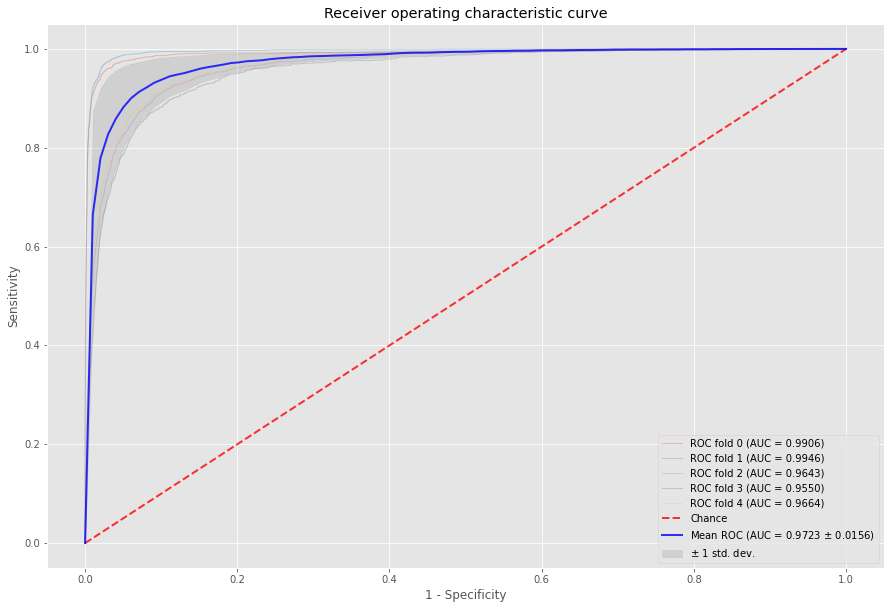

time: 5.68 s


In [26]:
 #plot_roc_curve(mortality, predictions)
 cross_validation_plot_roc_curve(ground_truth_training_set, predictions_training_set,
                               filename='roc_curve_training.png')

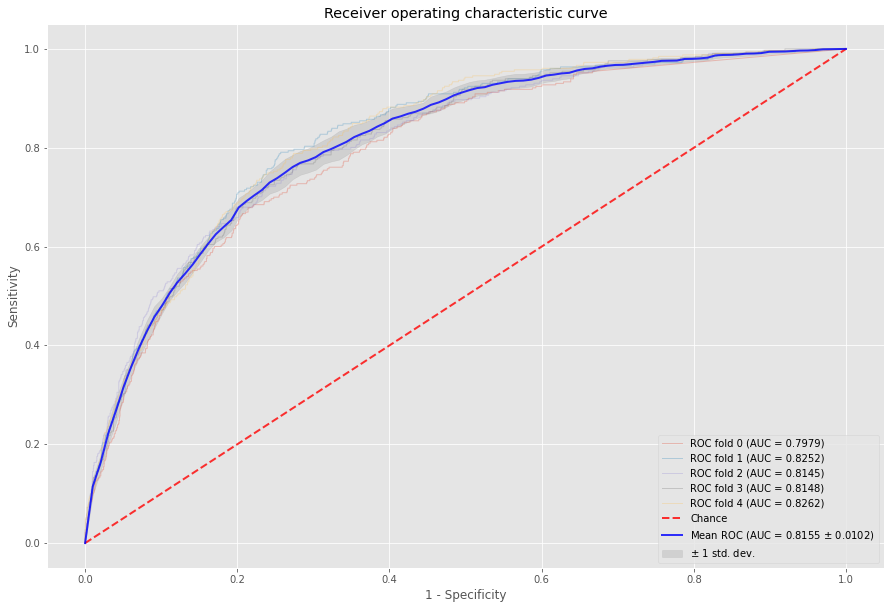

time: 5.98 s


In [27]:
cross_validation_plot_roc_curve(ground_truth, predictions, 
                                filename='roc_curve_validation.png')